# 0. Importing the libs and read the data

In [83]:
from pathlib import Path
import warnings
import json

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Test/Train/Val data split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# Import necessary for classification model selection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Import necessary for regression model selection
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# For saving the model
import pickle

# 1. Data preparation and data cleaning

In [84]:
rows = []

for file in Path("data").glob("*.json"):
    with open(file, "r") as f:
        data = json.load(f)
        rows.append(pd.DataFrame(data["ohlcv_data"]))

df = pd.concat(rows, ignore_index=True)

In [85]:
df.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
time       object
Volume    float64
dtype: object

In [86]:
df.shape

(365700, 7)

In [87]:
df.head()

,open,high,low,close,volume,time,Volume
0,57.641122,57.734019,56.201208,56.294106,26094342.0,2049-05-14 17:00:00+0300,NaN
1,56.201208,56.201208,56.201208,56.201208,1416452.0,2049-05-15 09:00:00+0300,NaN
2,56.201208,56.247657,55.736720,55.968964,15677280.0,2049-05-15 10:00:00+0300,NaN
3,55.968964,56.154759,55.783169,56.015413,7296407.0,2049-05-15 11:00:00+0300,NaN
4,55.968964,56.108311,55.968964,55.968964,3602435.0,2049-05-15 12:00:00+0300,NaN


In [88]:
# Clear the UTC from the time column
df["time"] = df["time"].str.split("+").str[0]

# Rename time column to datetime
df.rename(columns={"time": "datetime"}, inplace=True)

In [89]:
# Fix volume
df["volume_fixed"] = df["volume"].combine_first(df["Volume"])

# Drop redundant colums
df = df.drop(columns=["volume", "Volume"])
df = df.rename(columns={"volume_fixed": "volume"})

In [90]:
# Make sure datetime is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime just in case
df = df.sort_values('datetime').reset_index(drop=True)

In [91]:
df.head()

,open,high,low,close,datetime,volume
0,10.610846,10.636802,10.532977,10.558933,2030-01-01 10:00:00,366517.0
1,10.558933,10.662758,10.558933,10.584890,2030-01-01 11:00:00,190501.0
2,10.584890,10.584890,10.584890,10.584890,2030-01-01 12:00:00,119385.0
3,10.584890,10.584890,10.584890,10.584890,2030-01-01 13:00:00,81915.0
4,10.636802,10.636802,10.558933,10.584890,2030-01-01 14:00:00,336890.0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365700 entries, 0 to 365699
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   open      365700 non-null  float64       
 1   high      365700 non-null  float64       
 2   low       365700 non-null  float64       
 3   close     365700 non-null  float64       
 4   datetime  365700 non-null  datetime64[ns]
 5   volume    365700 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 16.7 MB


In [93]:
df.describe()

,open,high,low,close,datetime,volume
count,365700.000000,365700.000000,365700.000000,365700.000000,365700,3.657000e+05
mean,47.534699,47.754749,47.311581,47.532519,2040-06-06 17:29:01.299426048,6.198270e+06
min,0.785130,0.792165,0.778095,0.785130,2030-01-01 10:00:00,0.000000e+00
25%,9.603936,9.650013,9.559602,9.602886,2034-10-26 11:00:00,4.761068e+05
50%,20.120630,20.219279,20.021063,20.113698,2040-06-09 18:00:00,2.287868e+06
75%,62.412474,62.680366,62.127242,62.399343,2045-11-15 16:15:00,7.158064e+06
max,378.914701,380.250483,378.380388,378.914701,2051-02-21 11:00:00,2.639272e+08
std,58.467750,58.727296,58.203037,58.463612,NaN,1.102080e+07


# 2. Feature Engineering

In [94]:
# 1. Return of the previous candle
df['return_1'] = df['close'].pct_change()

# Replace NaN values resulting from pct_change
df['return_1'] = df['return_1'].fillna(0)

In [95]:
# 2. Range of the candle
df['range'] = df['high'] - df['low']

In [96]:
# 3. Body of the candle
df['body'] = (df['close'] - df['open']).abs()

In [97]:
# 4. Rolling volatility (std dev of close over last 5 candles)
df['volatility_5'] = df['close'].rolling(window=5).std()

In [98]:
# 5. Volume change
df['volume_change'] = df['volume'].pct_change()

# Drop all the rows that have infinite values in 'volume_change'
df = df[~df['volume_change'].isin([np.inf, -np.inf])]

In [99]:
# 6. Trend slope over last 5 candles (simple linear regression slope)
def rolling_slope(series, window=5):
    slopes = [np.nan] * (window-1)
    for i in range(window-1, len(series)):
        y = series[i-window+1:i+1].values
        x = np.arange(window)
        # slope = cov(x, y)/var(x)
        slope = np.polyfit(x, y, 1)[0]
        slopes.append(slope)
    return slopes

df['trend_slope_5'] = rolling_slope(df['close'], window=5)

In [100]:
# -------------------------
# Targets
# -------------------------
horizon = 10  # look 10 candles ahead

# 1. Classification target: 1 if price goes up in 10 candles, else 0
df['y_class'] = (df['close'].shift(-horizon) > df['close']).astype(int)

# 2. Regression target: future close price
df['y_reg'] = df['close'].shift(-horizon)

In [101]:
df.isnull().sum()

open              0
high              0
low               0
close             0
datetime          0
volume            0
return_1          0
range             0
body              0
volatility_5      4
volume_change     6
trend_slope_5     4
y_class           0
y_reg            10
dtype: int64

In [102]:
df = df.dropna().reset_index(drop=True)

In [103]:
df.shape

(364806, 14)

In [104]:
print(f"There where {365700 - 364806} rows dropped due to NaN and inf values.")

There where 894 rows dropped due to NaN and inf values.


In [105]:
df.head().T

,0,1,2,3,4
open,10.636802,10.58489,10.558933,10.481065,10.455109
high,10.636802,10.610846,10.610846,10.481065,10.455109
low,10.558933,10.558933,10.481065,10.351285,10.403197
close,10.58489,10.558933,10.481065,10.455109,10.403197
datetime,2030-01-01 14:00:00,2030-01-01 15:00:00,2030-01-01 16:00:00,2030-01-01 17:00:00,2030-01-02 09:00:00
volume,336890.0,214840.0,312632.0,295485.0,152509.0
return_1,0.0,-0.002452,-0.007375,-0.002476,-0.004965
range,0.077868,0.051912,0.12978,0.12978,0.051912
body,0.051912,0.025956,0.077868,0.025956,0.051912
volatility_5,0.011608,0.011608,0.044957,0.060872,0.074779


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364806 entries, 0 to 364805
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   open           364806 non-null  float64       
 1   high           364806 non-null  float64       
 2   low            364806 non-null  float64       
 3   close          364806 non-null  float64       
 4   datetime       364806 non-null  datetime64[ns]
 5   volume         364806 non-null  float64       
 6   return_1       364806 non-null  float64       
 7   range          364806 non-null  float64       
 8   body           364806 non-null  float64       
 9   volatility_5   364806 non-null  float64       
 10  volume_change  364806 non-null  float64       
 11  trend_slope_5  364806 non-null  float64       
 12  y_class        364806 non-null  int64         
 13  y_reg          364806 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory u

In [107]:
df.dtypes

open                    float64
high                    float64
low                     float64
close                   float64
datetime         datetime64[ns]
volume                  float64
return_1                float64
range                   float64
body                    float64
volatility_5            float64
volume_change           float64
trend_slope_5           float64
y_class                   int64
y_reg                   float64
dtype: object

In [108]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
open,364806.0,47.539878,0.78513,9.603918,20.116075,62.424371,378.914701,58.471899
high,364806.0,47.76021,0.792165,9.650013,20.212744,62.702576,380.250483,58.731816
low,364806.0,47.316473,0.778095,9.559468,20.019938,62.145781,378.380388,58.20686
close,364806.0,47.53771,0.78513,9.60286,20.109267,62.420022,378.914701,58.467786
datetime,364806,2040-06-06 06:50:22.716731392,2030-01-01 14:00:00,2034-10-25 16:00:00,2040-06-07 16:30:00,2045-11-15 15:00:00,2051-02-18 10:00:00,NaN
volume,364806.0,6202267.151064,0.0,476690.0,2291987.0,7168637.0,263927184.0,11021545.217763
return_1,364806.0,2.396576,-0.995167,-0.651813,0.0,1.868044,204.498411,7.770532
range,364806.0,0.443737,0.0,0.051797,0.137282,0.487173,19.863395,0.77966
body,364806.0,0.210437,0.0,0.012189,0.053015,0.186945,12.188021,0.467377
volatility_5,364806.0,45.411901,0.0,18.084564,41.071657,65.745111,198.419214,32.474083


# 3. Exploratory Data Analysis

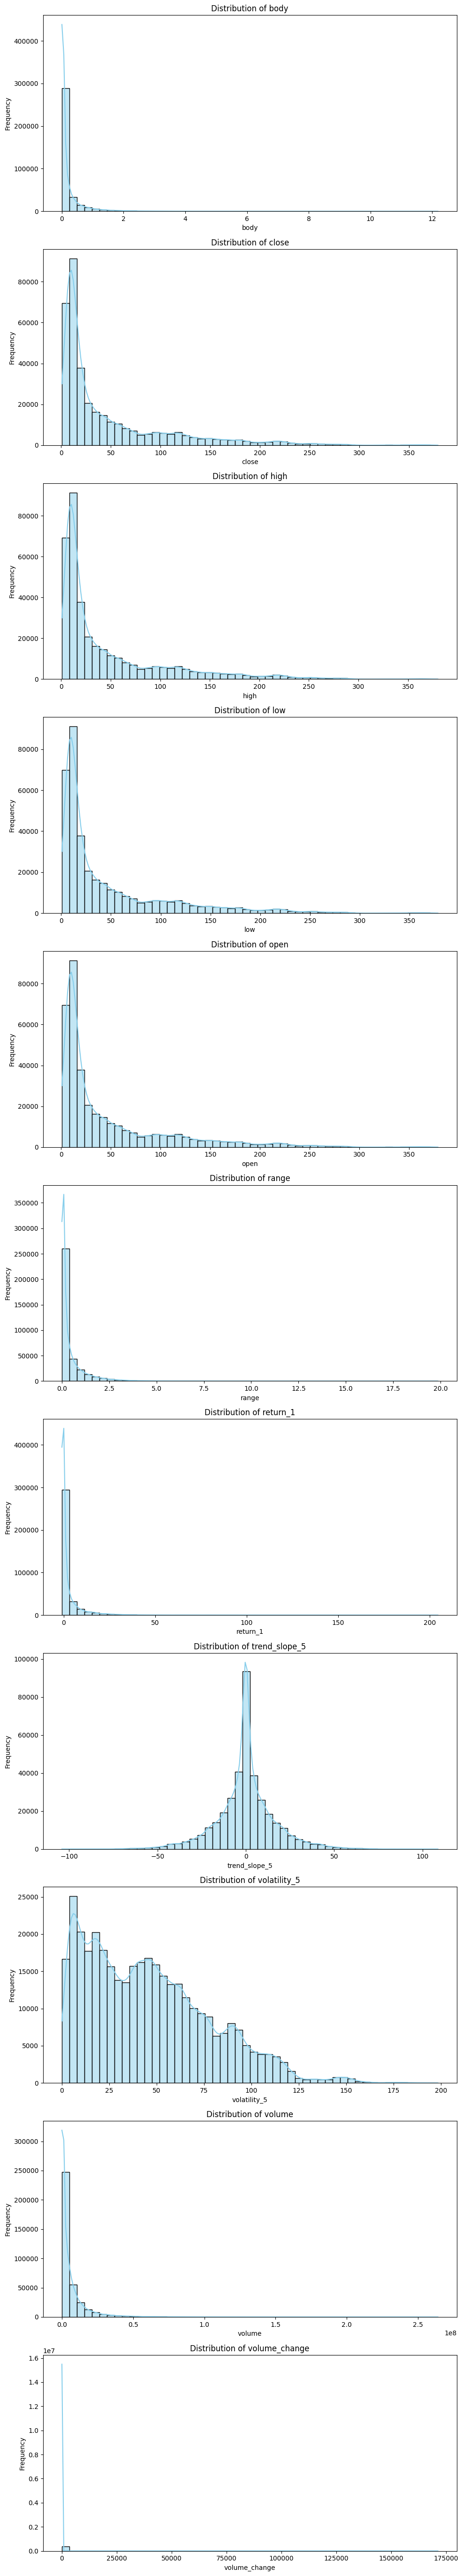

In [109]:
# Select only numeric columns excluding the targets
cols_to_plot = df.select_dtypes(include=['float64', 'int64']).columns.difference(['y_class', 'y_reg'])

# Set up the figure
plt.figure(figsize=(10, 5 * len(cols_to_plot)))  # make height proportional to number of columns

# Loop over columns and create a subplot for each
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(len(cols_to_plot), 1, i)  # vertical stack
    sns.histplot(df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

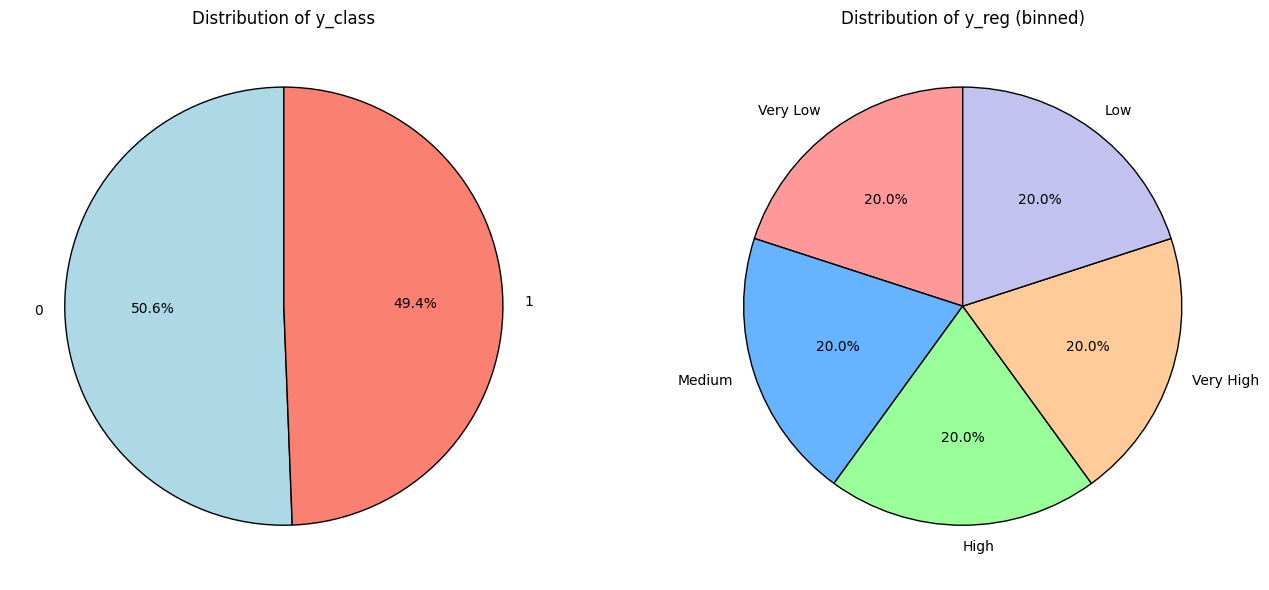

In [110]:
# --- Pie chart data ---
y_class_counts = df['y_class'].value_counts()

# Create 5 bins for y_reg
df['y_reg_bin'] = pd.qcut(df['y_reg'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
y_reg_counts = df['y_reg_bin'].value_counts()

# Define custom colors
y_class_colors = ['lightblue', 'salmon']
y_reg_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for y_class
axes[0].pie(y_class_counts, labels=y_class_counts.index, autopct='%1.1f%%', startangle=90, colors=y_class_colors, wedgeprops={'edgecolor':'black'})
axes[0].set_title('Distribution of y_class')

# Pie chart for y_reg (binned)
axes[1].pie(y_reg_counts, labels=y_reg_counts.index, autopct='%1.1f%%', startangle=90, colors=y_reg_colors, wedgeprops={'edgecolor':'black'})
axes[1].set_title('Distribution of y_reg (binned)')

plt.tight_layout()
plt.show()

In [111]:
df = df.drop(columns=['y_reg_bin'])

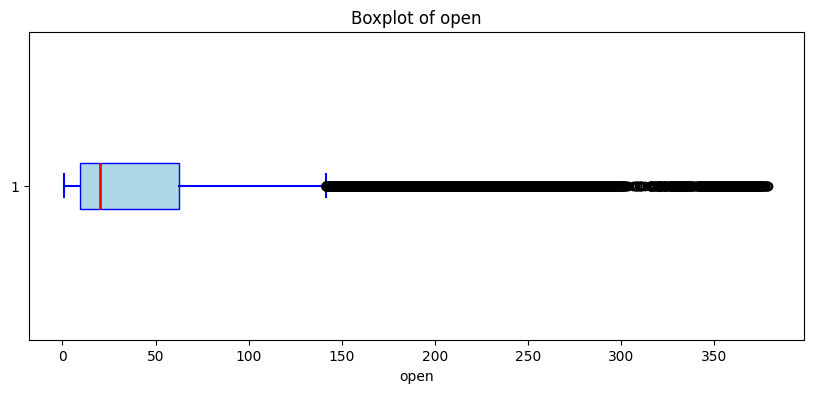

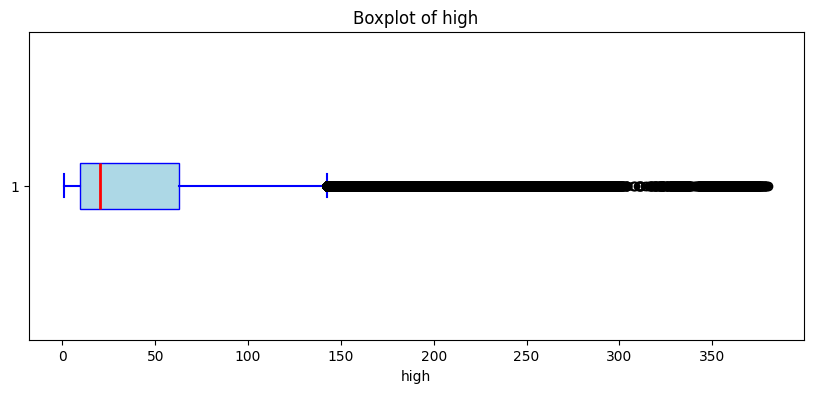

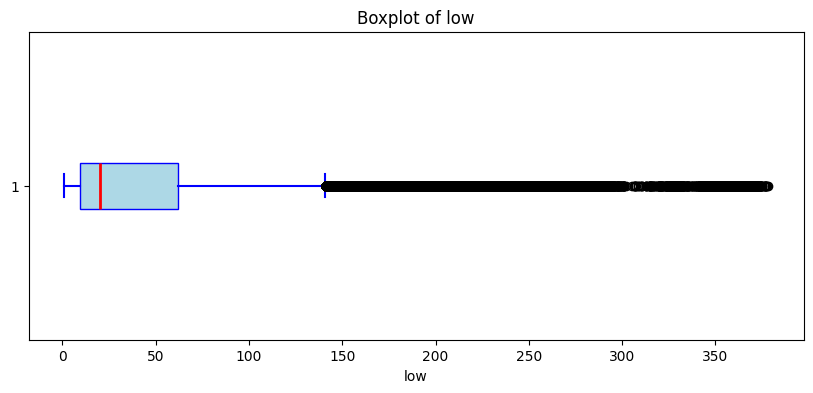

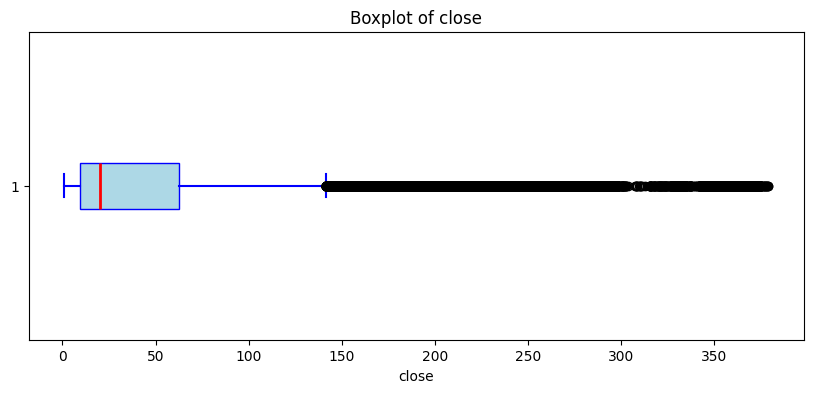

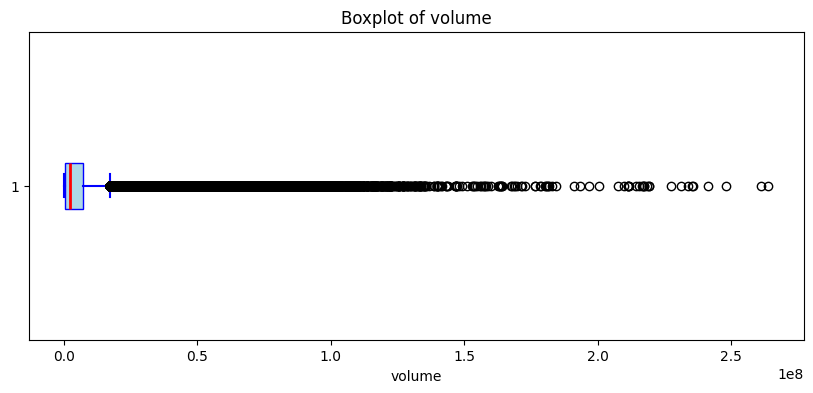

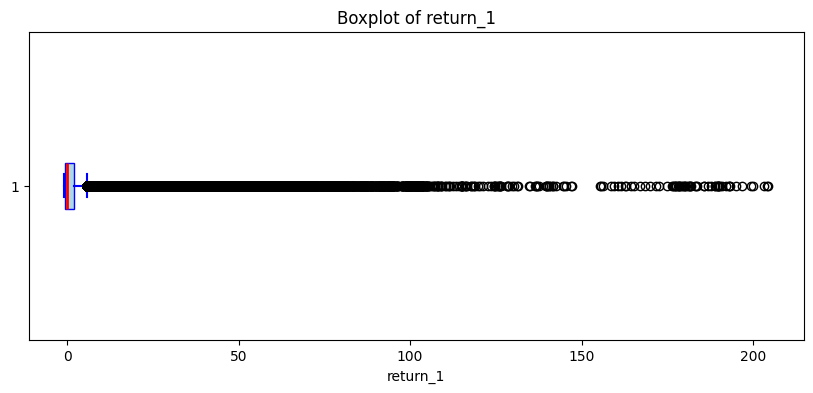

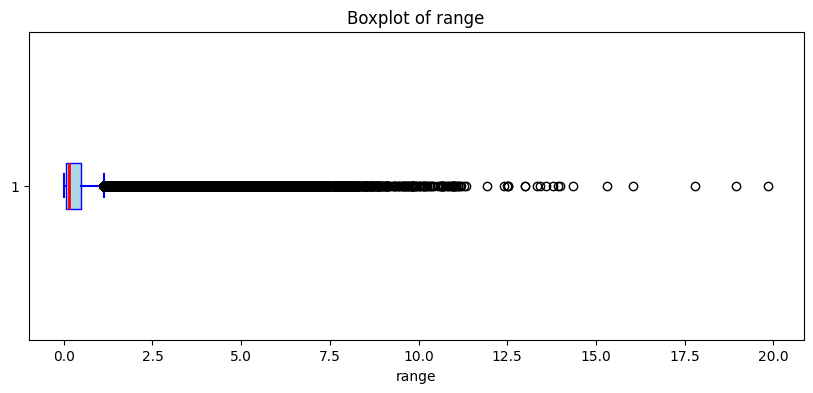

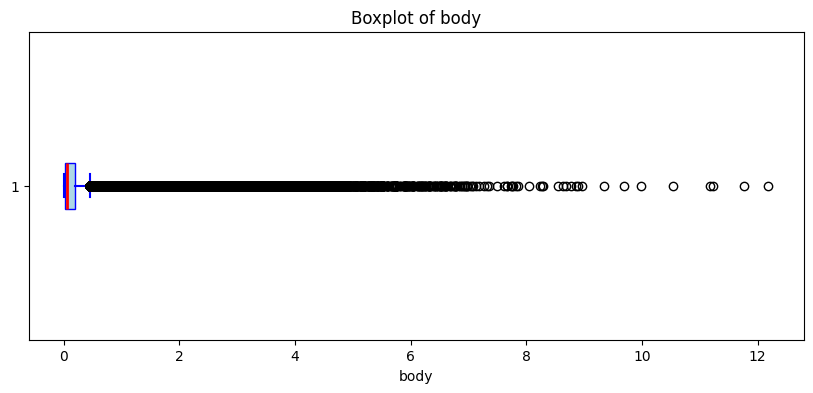

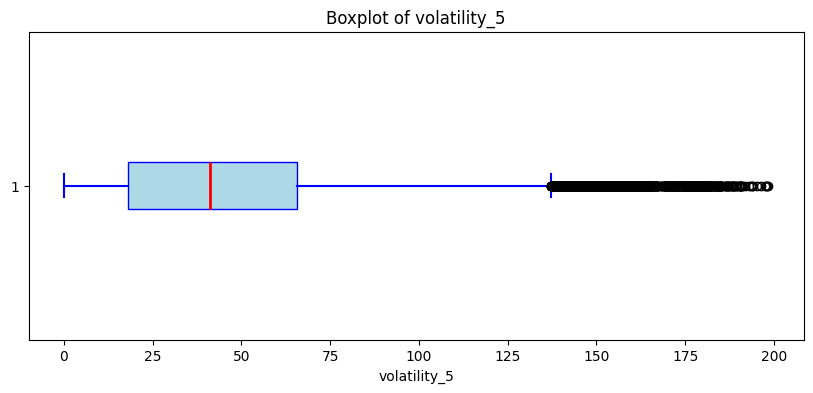

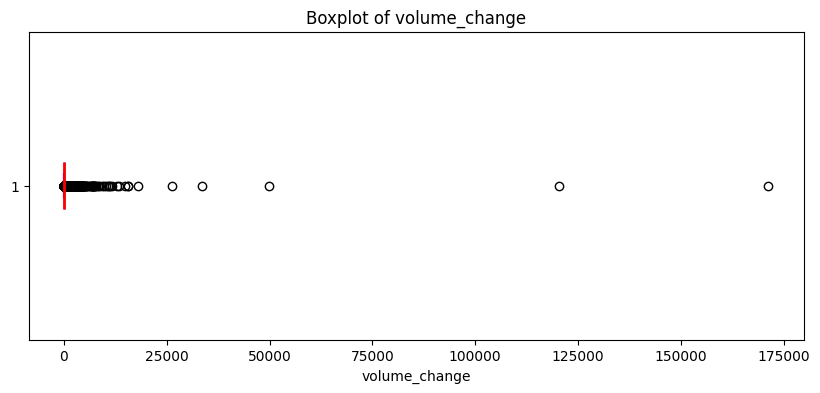

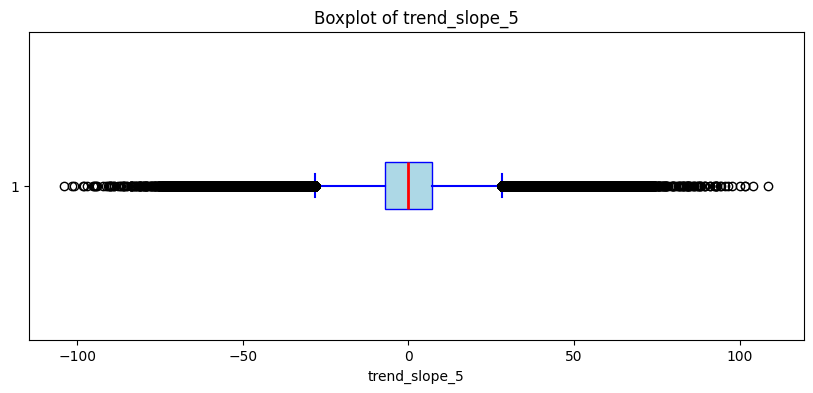

In [112]:
# Select numeric columns only, exclude y_class, y_reg, y_reg_bin
columns_to_plot = df.select_dtypes(include=['float64', 'int64']).columns
columns_to_plot = [col for col in columns_to_plot if col not in ['y_class', 'y_reg']]

# Create boxplots for each column
for col in columns_to_plot:
    plt.figure(figsize=(10, 4))
    plt.boxplot(df[col], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5),
                medianprops=dict(color='red', linewidth=2))
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

## Price Evolution

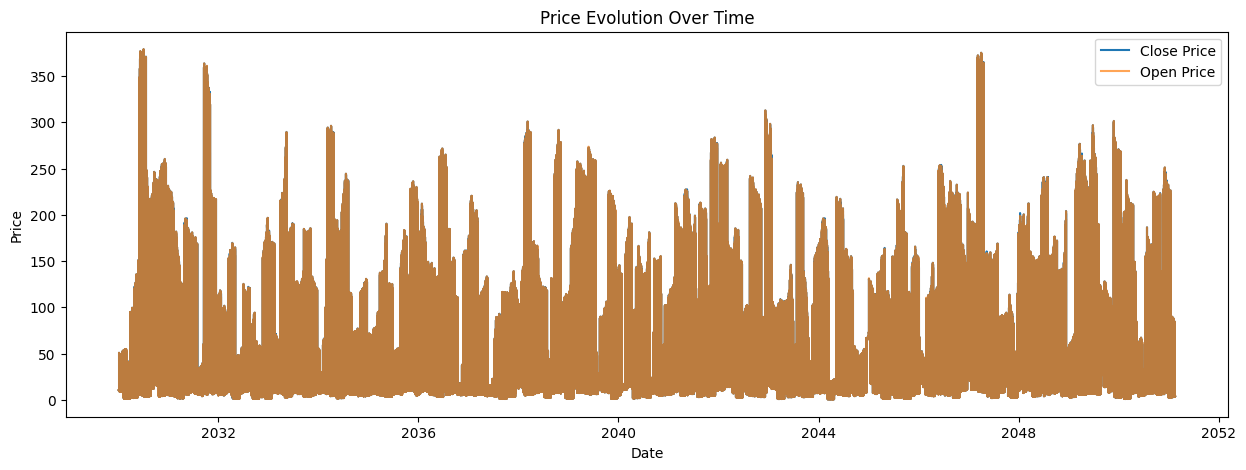

In [113]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['close'], label='Close Price')
plt.plot(df['datetime'], df['open'], label='Open Price', alpha=0.7)
plt.title('Price Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Volume over time

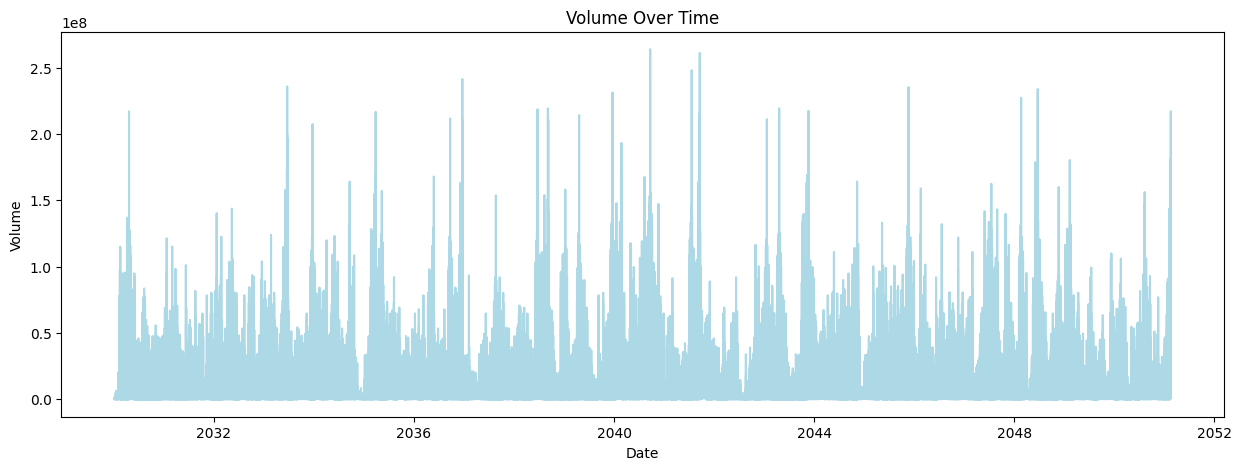

In [114]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['volume'], color='lightblue')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


## Rolling volatility / trend slope

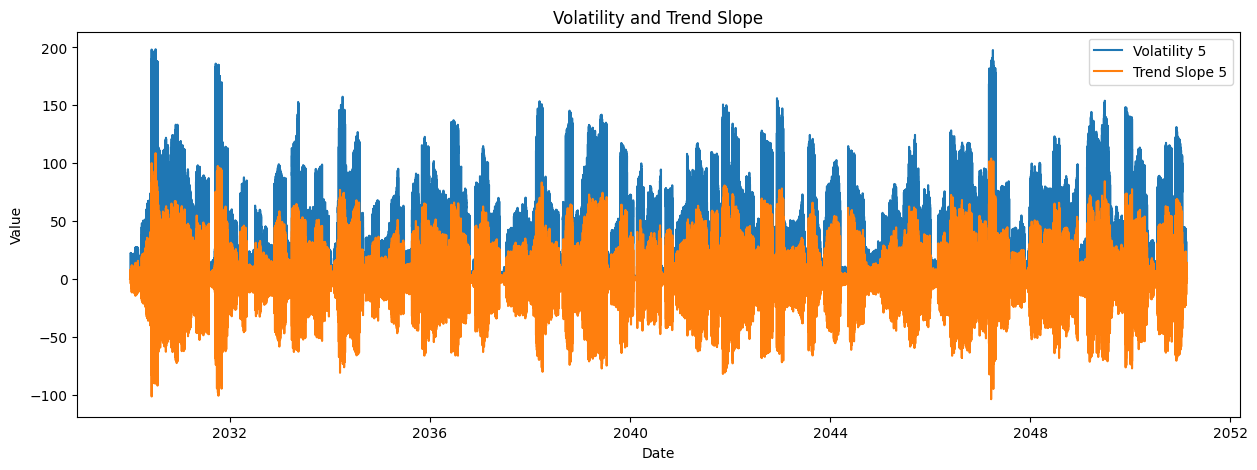

In [115]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['volatility_5'], label='Volatility 5')
plt.plot(df['datetime'], df['trend_slope_5'], label='Trend Slope 5')
plt.title('Volatility and Trend Slope')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Pairplots / Scatterplots

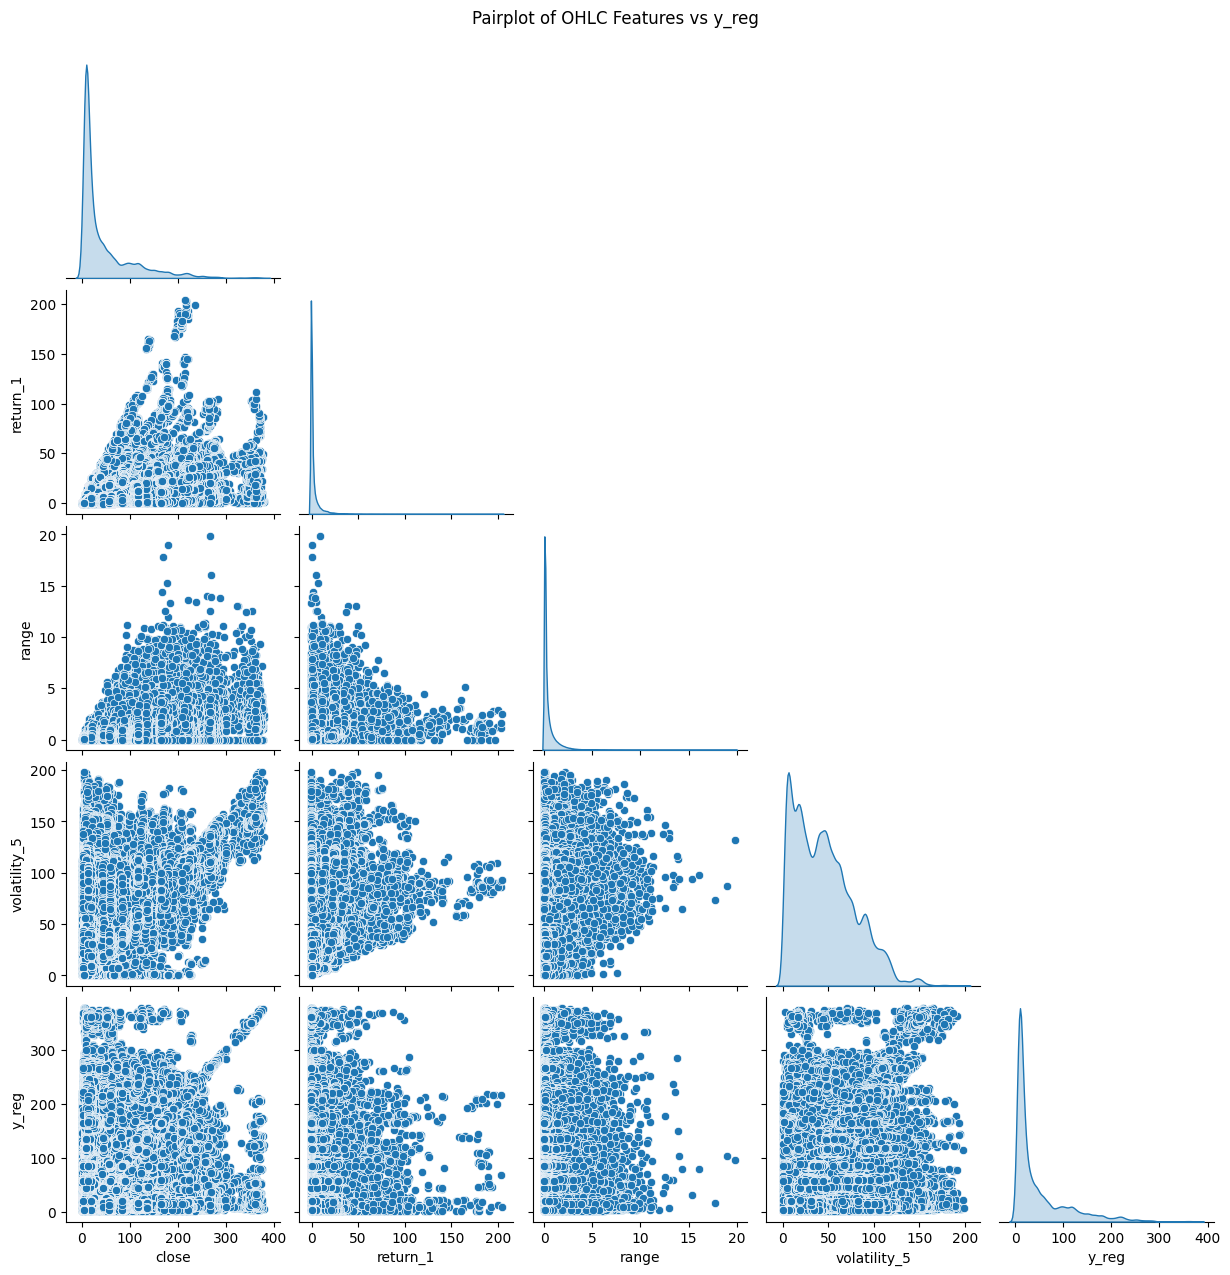

In [116]:
# Pairplot of selected columns
sns.pairplot(
    df[['close','return_1','range','volatility_5','y_reg']], 
    diag_kind='kde',  # Kernel Density Estimation for histograms on the diagonal
    corner=True        # Only shows lower triangle (no duplicate plots)
)
plt.suptitle('Pairplot of OHLC Features vs y_reg', y=1.02)
plt.show()

## Rolling Statistics

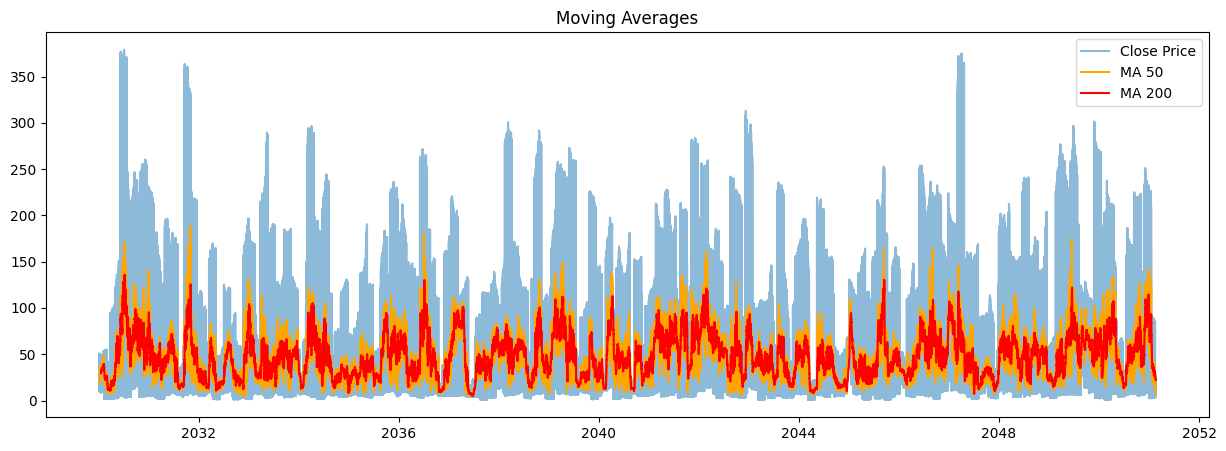

In [117]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['close'], label='Close Price', alpha=0.5)
plt.plot(df['datetime'], df['close'].rolling(window=50).mean(), label='MA 50', color='orange')
plt.plot(df['datetime'], df['close'].rolling(window=200).mean(), label='MA 200', color='red')
plt.title('Moving Averages')
plt.legend()
plt.show()

## Correlation Heatmap

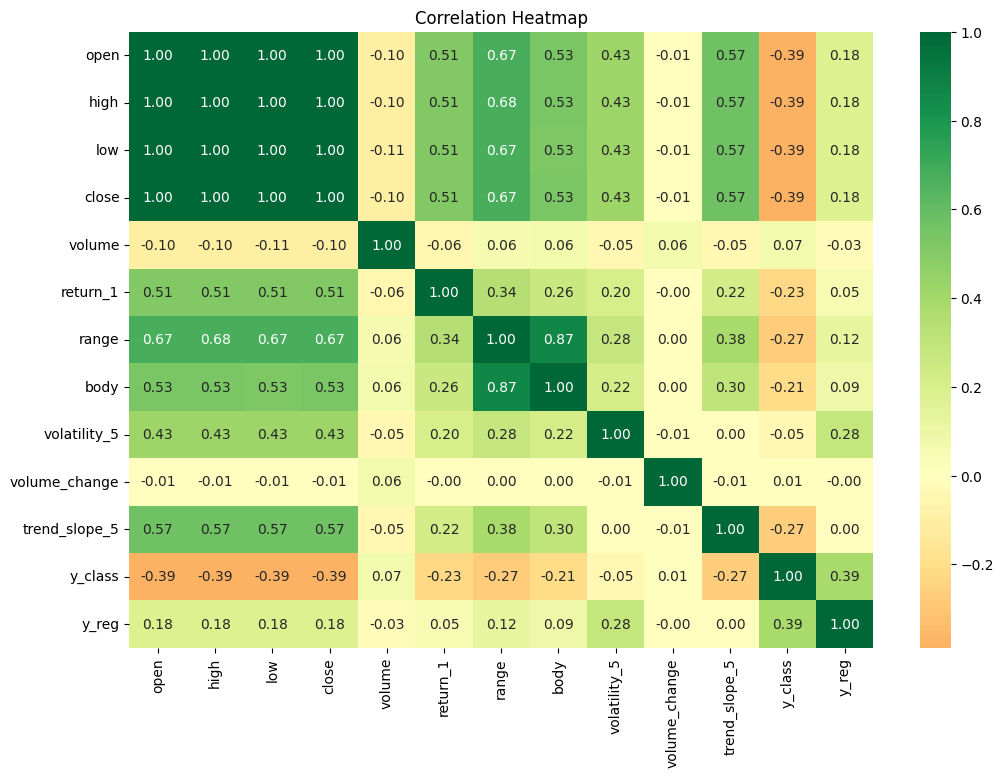

In [118]:
plt.figure(figsize=(12,8))

corr = df.select_dtypes(include='number').corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn", # red -> yellow -> green
    center=0       # 0 = neutral (yellow)
)

plt.title("Correlation Heatmap")
plt.show()

# 4. Feature and Target Selection

In [119]:
# Classification Target
classification_target = 'y_class'
target_classification = [classification_target]

# Regression Target
regression_target = 'y_reg'
target_regression = [regression_target]

# Classification Features: all features except the target column for classification
classification_features = df.drop(columns=[classification_target, regression_target, 'datetime'])

# Regression Features: all features except the target column for regression
regression_features = df.drop(columns=[regression_target, classification_target, 'datetime'])


In [120]:
print("Classification Features:")
print(list(classification_features.columns))

Classification Features:
['open', 'high', 'low', 'close', 'volume', 'return_1', 'range', 'body', 'volatility_5', 'volume_change', 'trend_slope_5']


In [121]:
print("\nClassification Target:")
print(classification_target)


Classification Target:
y_class


In [122]:
print("\nRegression Features:")
print(list(regression_features.columns))


Regression Features:
['open', 'high', 'low', 'close', 'volume', 'return_1', 'range', 'body', 'volatility_5', 'volume_change', 'trend_slope_5']


In [123]:
print("\nRegression Target:")
print(regression_target)


Regression Target:
y_reg


# 5. Split the data - Regression & Classification

- Split the data in train/val/test sets with 60%/20%/20% distribution.

In [124]:
# ---------------------- CLASSIFICATION SPLIT ----------------------

# Prepare the classification data (features + target)
df_classification = df[classification_features.columns.tolist() + target_classification]

# Split the data into training, validation, and test sets
df_class_full_train, df_class_test = train_test_split(df_classification, test_size=0.2, random_state=1)
df_class_train, df_class_val = train_test_split(df_class_full_train, test_size=0.25, random_state=1)

# Reset indices
df_class_train = df_class_train.reset_index(drop=True)
df_class_val = df_class_val.reset_index(drop=True)
df_class_test = df_class_test.reset_index(drop=True)

# Extract target variables (y_class)
y_class_train = df_class_train[classification_target].values
y_class_val = df_class_val[classification_target].values
y_class_test = df_class_test[classification_target].values

# Drop the target variable from the DataFrames
del df_class_train[classification_target]
del df_class_val[classification_target]
del df_class_test[classification_target]

# Print dataset sizes
print('Training set size:', len(df_class_train), f"{round(len(df_class_train) / (len(df_class_train) + len(df_class_val) + len(df_class_test)), 2)}")
print('Validation set size:', len(df_class_val), f"{round(len(df_class_val) / (len(df_class_train) + len(df_class_val) + len(df_class_test)), 2)}")
print('Test set size:', len(df_class_test), f"{round(len(df_class_test) / (len(df_class_train) + len(df_class_val) + len(df_class_test)), 2)}")

Training set size: 218883 0.6
Validation set size: 72961 0.2
Test set size: 72962 0.2


In [125]:
# Convert DataFrames to dictionaries
df_class_train_dicts = df_class_train.to_dict(orient='records')
df_class_val_dicts = df_class_val.to_dict(orient='records')
df_class_test_dicts = df_class_test.to_dict(orient='records')

In [126]:
# Vectorize the data
dv = DictVectorizer(sparse=True)
X_class_train = dv.fit_transform(df_class_train_dicts)
X_class_val = dv.transform(df_class_val_dicts)
X_class_test = dv.transform(df_class_test_dicts)

In [127]:
# ---------------------- REGRESSION SPLIT ----------------------

# Prepare the regression data (features + target)
df_regression = df[regression_features.columns.tolist() + target_regression]

# Split the data into training, validation, and test sets
df_reg_full_train, df_reg_test = train_test_split(df_regression, test_size=0.2, random_state=1)
df_reg_train, df_reg_val = train_test_split(df_reg_full_train, test_size=0.25, random_state=1)

# Reset indices
df_reg_train = df_reg_train.reset_index(drop=True)
df_reg_val = df_reg_val.reset_index(drop=True)
df_reg_test = df_reg_test.reset_index(drop=True)

# Extract target variables (y_reg)
y_reg_train = df_reg_train[regression_target].values
y_reg_val = df_reg_val[regression_target].values
y_reg_test = df_reg_test[regression_target].values

# Drop the target variable from the DataFrames
del df_reg_train[regression_target]
del df_reg_val[regression_target]
del df_reg_test[regression_target]

print('Training set size:', len(df_reg_train), f"{round(len(df_reg_train) / (len(df_reg_train) + len(df_reg_val) + len(df_reg_test)), 2)}")
print('Validation set size:', len(df_reg_val), f"{round(len(df_reg_val) / (len(df_reg_train) + len(df_reg_val) + len(df_reg_test)), 2)}")
print('Test set size:', len(df_reg_test), f"{round(len(df_reg_test) / (len(df_reg_train) + len(df_reg_val) + len(df_reg_test)), 2)}")

Training set size: 218883 0.6
Validation set size: 72961 0.2
Test set size: 72962 0.2


In [128]:
# Convert DataFrames to dictionaries
df_reg_train_dicts = df_reg_train.to_dict(orient='records')
df_reg_val_dicts = df_reg_val.to_dict(orient='records')
df_reg_test_dicts = df_reg_test.to_dict(orient='records')

In [129]:
# Vectorize the data
X_reg_train = dv.fit_transform(df_reg_train_dicts)
X_reg_val = dv.transform(df_reg_val_dicts)
X_reg_test = dv.transform(df_reg_test_dicts)

# 6. Classification Model - Choose the model

In [130]:
# Model Selection Process for Classification
def model_selection_classification(df, classification_features, classification_target='y_class'):
    print(f"=== MODEL SELECTION FOR {classification_target} ===")

    # Prepare data
    X = df[classification_features].copy()
    y = df[classification_target]

    # Check class distribution
    pos_rate = y.mean()
    print(f"Target '{classification_target}' - Positive cases: {y.sum()} ({pos_rate:.1%})")

    # Encode categorical variables (if any)
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()  # Automatically pick categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define models to test
    models = {
        # 'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=1),
        # 'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
    }

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store results
    results = []

    print("\n1. MODEL COMPARISON:")
    print("-" * 120)
    print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'Precision':<10} {'Recall':<10} {'ROC-AUC':<10} {'CV_Acc':<10} {'CV_F1':<10} {'CV_ROC':<10}")
    print("-" * 120)

    for name, model in models.items():
        # Cross-validation with multiple metrics
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
        cv_precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
        cv_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
        cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

        # Fit model and get test predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate test metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)

        # ROC-AUC for test set
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            test_roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            test_roc_auc = roc_auc_score(y_test, y_pred)

        results.append({
            'Model': name,
            'CV_Accuracy_Mean': cv_accuracy.mean(),
            'CV_Accuracy_Std': cv_accuracy.std(),
            'CV_F1_Mean': cv_f1.mean(),
            'CV_F1_Std': cv_f1.std(),
            'CV_Precision_Mean': cv_precision.mean(),
            'CV_Recall_Mean': cv_recall.mean(),
            'CV_ROC_AUC_Mean': cv_roc_auc.mean(),
            'Test_Accuracy': test_accuracy,
            'Test_F1': test_f1,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_ROC_AUC': test_roc_auc
        })

        # Print with all key metrics including CV scores (without std deviation)
        print(f"{name:<20} {test_accuracy:<10.3f} {test_f1:<10.3f} {test_precision:<10.3f} {test_recall:<10.3f} {test_roc_auc:<10.3f} {cv_accuracy.mean():<10.3f} {cv_f1.mean():<10.3f} {cv_roc_auc.mean():<10.3f}")

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Find best models for different metrics
    best_accuracy = results_df.loc[results_df['Test_Accuracy'].idxmax(), 'Model']
    best_f1 = results_df.loc[results_df['Test_F1'].idxmax(), 'Model']
    best_roc_auc = results_df.loc[results_df['Test_ROC_AUC'].idxmax(), 'Model']

    print(f"\n2. BEST MODELS:")
    print(f"Best Accuracy: {best_accuracy} ({results_df['Test_Accuracy'].max():.3f})")
    print(f"Best F1-Score: {best_f1} ({results_df['Test_F1'].max():.3f})")
    print(f"Best ROC-AUC: {best_roc_auc} ({results_df['Test_ROC_AUC'].max():.3f})")

    # Calculate baseline performance
    baseline_accuracy = max(pos_rate, 1-pos_rate)
    print(f"\n3. BASELINE COMPARISON:")
    print(f"Majority class baseline: {baseline_accuracy:.3f}")
    print(f"Best model improvement: +{results_df['Test_Accuracy'].max() - baseline_accuracy:.3f}")

    # Warning for suspicious results
    if results_df['Test_Accuracy'].max() > 0.95 and pos_rate < 0.1:
        print("\nWARNING: Very high accuracy with low positive rate - check for data leakage!")

    return results_df, X_train, X_test, y_train, y_test, models

In [131]:
results_df__select_class, \
X_train___select_class, \
X_test__select_class, \
y_train__select_class,\
y_test__select_class, \
models__select_class = model_selection_classification(
    df, 
    classification_features=classification_features.columns.tolist(),
    classification_target='y_class'
)

=== MODEL SELECTION FOR y_class ===
Target 'y_class' - Positive cases: 180170 (49.4%)

1. MODEL COMPARISON:
------------------------------------------------------------------------------------------------------------------------
Model                Accuracy   F1-Score   Precision  Recall     ROC-AUC    CV_Acc     CV_F1      CV_ROC    
------------------------------------------------------------------------------------------------------------------------
Logistic Regression  0.697      0.699      0.686      0.712      0.749      0.691      0.690      0.746     
Gradient Boosting    0.719      0.720      0.710      0.731      0.793      0.719      0.720      0.791     
XGBoost              0.720      0.719      0.713      0.725      0.793      0.719      0.719      0.791     

2. BEST MODELS:
Best Accuracy: XGBoost (0.720)
Best F1-Score: Gradient Boosting (0.720)
Best ROC-AUC: Gradient Boosting (0.793)

3. BASELINE COMPARISON:
Majority class baseline: 0.506
Best model improvement: +0.21

# 6. Classification Model - XGBClassifier - Hyperparameter Tunning

In [132]:
# Calculate the positive class rate
pos_rate = y_class_train.mean()

# Initialize the XGBoost model
xgb_model_class = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=(1 - pos_rate) / pos_rate,
    random_state=42,
    n_jobs=-1
)

# Define the parameter grid for RandomizedSearchCV
param_grid_class = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.5, 1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 3, 5, 7]
}

# Create the RandomizedSearchCV instance
grid_search_class = RandomizedSearchCV(
    estimator=xgb_model_class,
    param_distributions=param_grid_class,
    n_iter=150,            # Number of random combinations to try
    cv=5,                  # 5-fold cross-validation
    scoring='roc_auc',     # Use ROC-AUC as the evaluation metric
    verbose=3,             # Set verbosity level to see progress
    n_jobs=-1,             # Use all available CPU cores
    random_state=42        # For reproducibility
)

# Fit the RandomizedSearchCV with the training data
print("\n=== TUNING XGBOOST ===")
grid_search_class.fit(X_class_train, y_class_train)

# Print out the best parameters and best score
print(f"\nBest hyperparameters: {grid_search_class.best_params_}")
print(f"Best CV ROC-AUC score: {grid_search_class.best_score_:.4f}")


=== TUNING XGBOOST ===
Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=0.787 total time=   2.4s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=0.790 total time=   2.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=0.794 total time=   2.5s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=0.791 total time=   2.5s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=0.792 total time= 

# 7. Classification Model - XGBClassifier - Model Evaluation

In [133]:
best_model_class = grid_search_class.best_estimator_
y_class_probs = best_model_class.predict_proba(X_class_val)[:, 1]
y_class_preds = best_model_class.predict(X_class_val)

acc = accuracy_score(y_class_val, y_class_preds)
f1 = f1_score(y_class_val, y_class_preds)
prec = precision_score(y_class_val, y_class_preds)
rec = recall_score(y_class_val, y_class_preds)
roc_auc = roc_auc_score(y_class_val, y_class_probs)

print("\n=== VALIDATION METRICS (XGBoost) ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


=== VALIDATION METRICS (XGBoost) ===
Accuracy: 0.7234
F1-Score: 0.7257
Precision: 0.7173
Recall: 0.7344
ROC-AUC: 0.7965


In [134]:
# ==================== THRESHOLD OPTIMIZATION ====================
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_class_val, (y_class_probs > t).astype(int)) if np.sum((y_class_probs > t).astype(int)) > 0 else 0 for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"F1-Score at optimal threshold: {np.max(f1_scores):.4f}")

# Recompute predictions with optimal threshold
y_preds_opt = (y_class_probs > optimal_threshold).astype(int)
f1_opt = f1_score(y_class_val, y_preds_opt)
acc_opt = accuracy_score(y_class_val, y_preds_opt)

print(f"Accuracy at optimal threshold: {acc_opt:.4f}")
print(f"F1-Score at optimal threshold: {f1_opt:.4f}")


Optimal threshold: 0.380
F1-Score at optimal threshold: 0.7437
Accuracy at optimal threshold: 0.7024
F1-Score at optimal threshold: 0.7437


<Figure size 800x600 with 0 Axes>

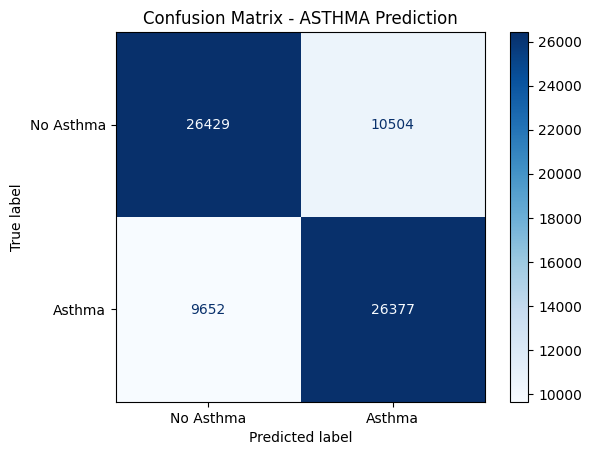

In [135]:
y_pred = best_model_class.predict(X_class_test)
cm = confusion_matrix(y_class_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Asthma', 'Asthma'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - ASTHMA Prediction')
plt.show()


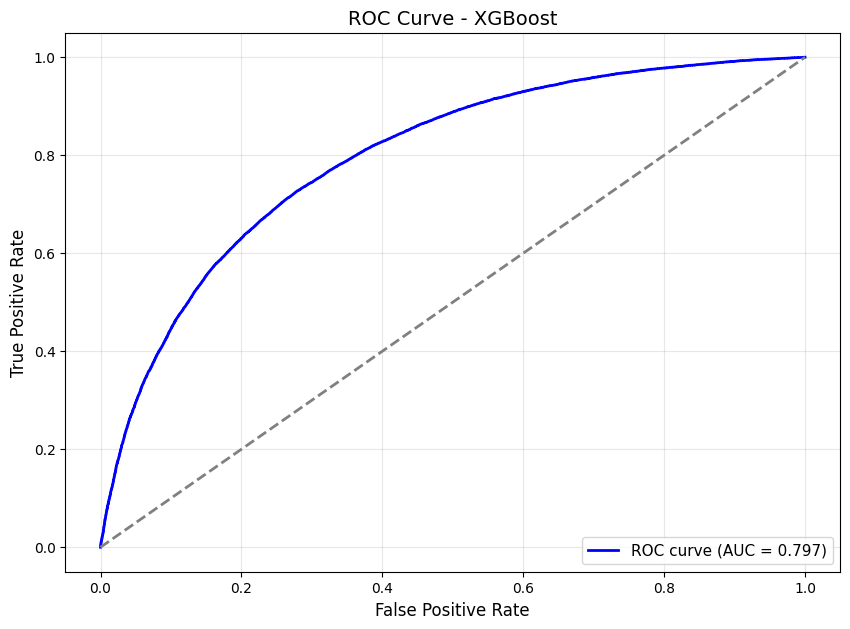

In [136]:
# ==================== ROC CURVE PLOT ====================
fpr, tpr, _ = roc_curve(y_class_val, y_class_probs)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.show()

# 8. Classification Model - XGBClassifier - Save the Model

In [137]:
class_output_file = f'./models/model_xgb_class.bin'
class_output_file

'./models/model_xgb_class.bin'

In [138]:
with open(class_output_file, 'wb') as f_out:
    pickle.dump((dv, best_model_class), f_out)

# 9. Regression Model - Choose the model

In [139]:
def model_selection_regression(df_reg_train, df_reg_val, df_reg_test, y_reg_train, y_reg_val, y_reg_test):
    # Prepare data
    X_train = df_reg_train.copy()
    X_val = df_reg_val.copy()
    X_test = df_reg_test.copy()
  
    # Handle missing values (fill NaN with -1 for _START columns, if needed)
    allergy_start_cols = [col for col in X_train.columns if col.endswith('_START')]
    for col in allergy_start_cols:
        X_train[col] = X_train[col].fillna(-1)
        X_val[col] = X_val[col].fillna(-1)
        X_test[col] = X_test[col].fillna(-1)
  
    # Encode categorical variables (if any, based on your features)
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()  # Automatically detect categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
  
    # Define models to test
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'Lasso Regression': Lasso(alpha=1.0, random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    }
  
    # Cross-validation setup
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train_val = pd.concat([X_train, X_val], ignore_index=True)
    y_train_val = np.concatenate([y_reg_train, y_reg_val])
  
    results = []
  
    print("1. MODEL COMPARISON:")
    print("-" * 140)
    print(f"{'Model':<20} {'Val_RMSE':<12} {'Test_RMSE':<12} {'Val_MAE':<10} {'Test_MAE':<10} {'Val_R2':<10} {'Test_R2':<10} {'CV_RMSE':<12}")
    print("-" * 140)
  
    for name, model in models.items():
        # Cross-validation (compute RMSE)
        cv_mse = cross_val_score(model, X_train_val, y_train_val, cv=cv, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_mse)
      
        # Fit and evaluate
        model.fit(X_train, y_reg_train)
      
        # Validation metrics
        y_val_pred = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_reg_val, y_val_pred))
        val_mae = mean_absolute_error(y_reg_val, y_val_pred)
        val_r2 = r2_score(y_reg_val, y_val_pred)
      
        # Test metrics
        y_test_pred = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_reg_test, y_test_pred))
        test_mae = mean_absolute_error(y_reg_test, y_test_pred)
        test_r2 = r2_score(y_reg_test, y_test_pred)
      
        # Store results
        results.append({
            'Model': name,
            'Val_RMSE': val_rmse,
            'Val_MAE': val_mae,
            'Val_R2': val_r2,
            'Test_RMSE': test_rmse,
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'CV_RMSE': cv_rmse.mean()
        })
      
        # Print results
        print(f"{name:<20} {val_rmse:<12.3f} {test_rmse:<12.3f} {val_mae:<10.3f} {test_mae:<10.3f} {val_r2:<10.3f} {test_r2:<10.3f} {cv_rmse.mean():<12.3f}")
  
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
  
    # Find best models based on different metrics
    best_rmse_idx = results_df['Val_RMSE'].idxmin()
    best_mae_idx = results_df['Val_MAE'].idxmin()
    best_r2_idx = results_df['Val_R2'].idxmax()
  
    print(f"\n2. BEST MODELS (Based on Validation Set):")
    print(f"Best Validation RMSE: {results_df.loc[best_rmse_idx, 'Model']} ({results_df.loc[best_rmse_idx, 'Val_RMSE']:.3f})")
    print(f"  → Test RMSE: {results_df.loc[best_rmse_idx, 'Test_RMSE']:.3f}")
    print(f"Best Validation MAE: {results_df.loc[best_mae_idx, 'Model']} ({results_df.loc[best_mae_idx, 'Val_MAE']:.3f})")
    print(f"  → Test MAE: {results_df.loc[best_mae_idx, 'Test_MAE']:.3f}")
    print(f"Best Validation R²: {results_df.loc[best_r2_idx, 'Model']} ({results_df.loc[best_r2_idx, 'Val_R2']:.3f})")
    print(f"  → Test R²: {results_df.loc[best_r2_idx, 'Test_R2']:.3f}")
  
    return results_df

In [140]:
results_df = model_selection_regression(
    df_reg_train, df_reg_val, df_reg_test, y_reg_train, y_reg_val, y_reg_test
)

1. MODEL COMPARISON:
--------------------------------------------------------------------------------------------------------------------------------------------
Model                Val_RMSE     Test_RMSE    Val_MAE    Test_MAE   Val_R2     Test_R2    CV_RMSE     
--------------------------------------------------------------------------------------------------------------------------------------------
Linear Regression    56.126       55.702       41.326     41.183     0.094      0.088      55.844      
Ridge Regression     56.126       55.702       41.326     41.183     0.094      0.088      55.844      
Lasso Regression     56.128       55.703       41.337     41.192     0.094      0.088      55.844      
XGBoost              56.002       55.481       40.261     40.075     0.098      0.095      55.742      

2. BEST MODELS (Based on Validation Set):
Best Validation RMSE: XGBoost (56.002)
  → Test RMSE: 55.481
Best Validation MAE: XGBoost (40.261)
  → Test MAE: 40.075
Best Validatio

# 10. Regression Model - XGBRegressor - Hyperparameter Tunning

In [141]:
# Initialize the XGBoost Regressor model
xgb_model_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # Objective for regression (mean squared error)
    eval_metric='rmse',            # Root Mean Squared Error (RMSE) as evaluation metric
    random_state=42,
    n_jobs=-1
)

# Define the parameter grid for RandomizedSearchCV
param_grid_reg = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.5, 1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 3, 5, 7]
}

# Create the RandomizedSearchCV instance for regression
grid_search_reg = RandomizedSearchCV(
    estimator=xgb_model_reg,
    param_distributions=param_grid_reg,
    n_iter=150,            # Number of random combinations to try
    cv=5,                  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',  # Use negative RMSE for scoring (since cross_val_score minimizes)
    verbose=3,             # Set verbosity level to see progress
    n_jobs=-1,             # Use all available CPU cores
    random_state=42        # For reproducibility
)

# Fit the RandomizedSearchCV with the training data
print("\n=== TUNING XGBOOST REGRESSION ===")
grid_search_reg.fit(X_reg_train, y_reg_train)

# Print out the best parameters and best score
print(f"\nBest hyperparameters: {grid_search_reg.best_params_}")
print(f"Best CV RMSE score: {-grid_search_reg.best_score_:.4f}") # Negate the score because it was minimized


=== TUNING XGBOOST REGRESSION ===
Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=-55.218 total time=   2.5s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=-55.408 total time=   2.5s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=-55.297 total time=   2.5s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score=-55.025 total time=   2.5s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=0.5, reg_lambda=0.5, subsample=0.9;, score

# 11. Regression Model - XGBRegressor - Model Evaluation

In [142]:
# Assuming you have the best model from grid search
best_model_reg = grid_search_reg.best_estimator_

# Make predictions on test set
y_reg_pred = best_model_reg.predict(X_reg_test)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
test_mae = mean_absolute_error(y_reg_test, y_reg_pred)
test_r2 = r2_score(y_reg_test, y_reg_pred)

print("=== REGRESSION MODEL PERFORMANCE ===")
print(f"RMSE: {test_rmse:.3f}")
print(f"MAE:  {test_mae:.3f}")
print(f"R²:   {test_r2:.3f}")

=== REGRESSION MODEL PERFORMANCE ===
RMSE: 55.090
MAE:  40.105
R²:   0.108


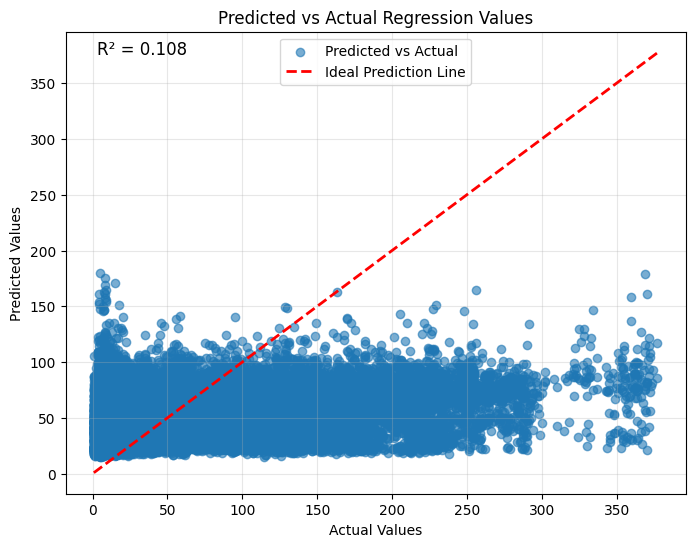

In [143]:
# Simple scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6, label='Predicted vs Actual')

# Plot the diagonal line (ideal prediction line)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', linewidth=2, label="Ideal Prediction Line")

# Labeling the axes
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Regression Values')

# Display R² on the plot
plt.text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=plt.gca().transAxes, fontsize=12)

# Show the grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.show()

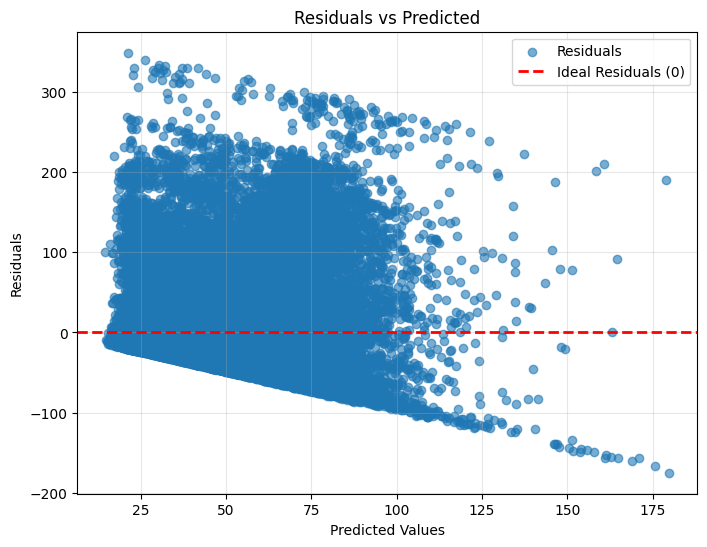

In [144]:
# Calculate the residuals (Actual - Predicted)
residuals = y_reg_test - y_reg_pred

# Create the residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_pred, residuals, alpha=0.6, label='Residuals')

# Add a red horizontal line at y=0 (ideal residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label="Ideal Residuals (0)")

# Label the axes
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Add title
plt.title('Residuals vs Predicted')

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.show()

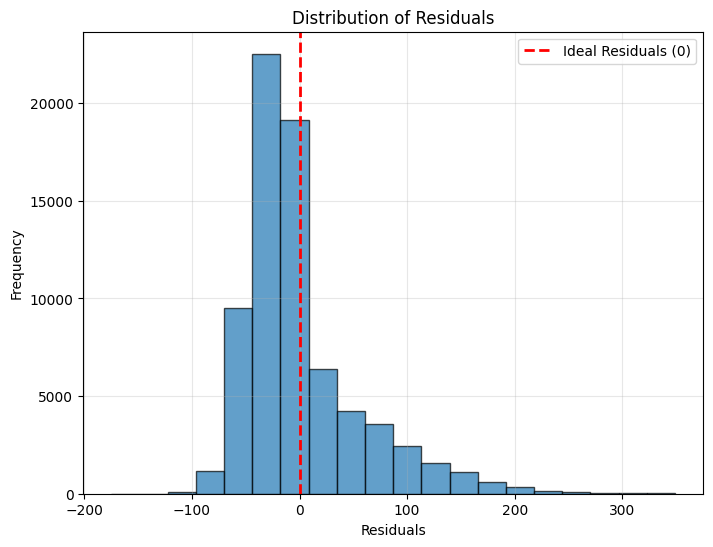

In [145]:
# Create histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)

# Add a vertical line at x=0 (ideal residuals value)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Ideal Residuals (0)')

# Label the axes
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Add title
plt.title('Distribution of Residuals')

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.show()

# 11. Regression Model - XGBRegressor - Save the Model

In [146]:
reg_output_file = f'./models/model_xgb_reg.bin'
reg_output_file

'./models/model_xgb_reg.bin'

In [147]:
with open(reg_output_file, 'wb') as f_out:
    pickle.dump((dv, best_model_reg), f_out)